# <font color='paleturquoise'>Time series anomaly detection</font>
Dataset origin: https://www.kaggle.com/datasets/caesarlupum/benchmark-labeled-anomaly-detection-ts/

 # Imports & functions

In [1]:
import pandas as pd
import numpy as np
import math
#connect to drive
from google.colab import drive
# visualisation
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
# split data
from sklearn.model_selection import train_test_split
# results
from sklearn.metrics import confusion_matrix, classification_report
# seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
# unbalanced data
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks


In [2]:
# isolation forest
from sklearn.ensemble import IsolationForest

In [3]:
#auto encoder
import torch
import torch.nn as nn
import torch.utils.data as data_utils


In [49]:
#DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn import decomposition

In [4]:
#vis scatter plot, x is time, y is value, differnet color for labels, pie chart to see the percent of outliers
def viz_labeled_time_series(df,time_col_name,value_col_name,label_col_name):
  fig = px.scatter(df, x=time_col_name, y=value_col_name, color=label_col_name, symbol=label_col_name,color_discrete_sequence=['navy','salmon'],title='Time seires over time with labels',width=1300, height=500)
  fig.show()

  fig = px.scatter(df, x=time_col_name, y=value_col_name,color=label_col_name , title='Time seires over time with labels and Rangeslider',symbol=label_col_name,color_discrete_sequence=['navy','salmon'],width=1300, height=500)
  fig.update_xaxes(rangeslider_visible=True)
  fig.show()

  fig = px.pie(df, names=label_col_name,color_discrete_sequence=['navy','salmon'],title='Label distrabution',width=300, height=300) # Setting Heart_ stroke as the label
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

In [5]:
#vis scatter plot, x is time, y is value, differnet color for labels, pie chart to see the percent of outliers
def viz_true_vs_pred_labels(df,time_col_name,value_col_name,confusion_matrix):
  fig = px.scatter(df, x=time_col_name, y=value_col_name,color=confusion_matrix , title='Time seires over time with labels',symbol=confusion_matrix,symbol_sequence= ['circle-open', 'circle', 'x', 'x-open'],color_discrete_sequence=['lightskyblue','navy','salmon','tomato'],width=1300, height=500)
  fig.show()

  fig = px.scatter(df, x=time_col_name, y=value_col_name,color=confusion_matrix , title='Time seires over time with labels and Rangeslider',symbol=confusion_matrix,symbol_sequence= ['circle-open', 'circle', 'x', 'x-open'],color_discrete_sequence=['lightskyblue','navy','salmon','tomato'],width=1300, height=500)
  fig.update_xaxes(rangeslider_visible=True)
  fig.show()

In [6]:
def over_sampling_adasyn(X_uner,y_under,percent_to_over_sample,adasyn_neighbors=5,adasyn_method='minority'):
  print('Original dataset shape %s' % Counter(y_under))
  X_avoid_over_fitting, X_for_over_sampling,y_avoid_over_fitting, y_for_over_sampling = train_test_split(X_uner, y_under, test_size=percent_to_over_sample, random_state=42)
  print('Original dataset sampled randonly for over sampling shape %s' % Counter(y_for_over_sampling))
  print('Original dataset sampled to keep as is (avoiding overfitting) shape %s' % Counter(y_avoid_over_fitting))
  ada = ADASYN(random_state=42,n_neighbors=adasyn_neighbors,sampling_strategy=adasyn_method)
  # 'minority': resample only the minority class;
  # 'not minority': resample all classes but the minority class;
  # 'not majority': resample all classes but the majority class;
  # 'all': resample all classes;
  # 'auto': equivalent to 'not majority'
  X_balanced, y_balanced = ada.fit_resample(X_for_over_sampling,y_for_over_sampling)
  print('Resampled dataset (after over sampling) shape %s' % Counter(y_balanced))
  X_good_balanced = pd.concat([X_balanced, X_avoid_over_fitting])
  y_good_balanced = pd.concat([y_balanced, y_avoid_over_fitting])
  #print("final ",X_good_balanced.shape,", over sampled ",X_balanced.shape,", non handeled to avoid overfit",X_avoid_over_fitting.shape)
  print('Resampled dataset (final) shape %s' % Counter(y_good_balanced))
  return X_good_balanced, y_good_balanced

##### For Autoencoder

In [7]:
# Generated training sequences for use in the model.
# like spliting: 1,2,3,4,5,6,7,8,9, for step =3 into: [[1],[2],[3]],[[2],[3],[4]],[[[3],[4],[5]]]... so the label is the prediction of the next one
def create_sequences(values, time_steps): # time steps = number of samples each minute/hour/day... this will be the amount of columns
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [8]:
# Reverse sequences into a vector (for results comparison)
# like "combining":  [[1],[2],[3]],[[2],[3],[4]],[[[3],[4],[5]]]... into : 1,2,3,4,5,6,7,8,9, for step =3
# time steps = number of samples each minute/hour/day... this will be the amount of columns, step=input_array.shape[1]

def reverse_sequences_to_vector(input_array):
  step=input_array.shape[1]
  avgs = []
  group_of_rows = input_array[0:step]
  for k in range (0,step-1): # for the numbers in the begining that apear less than the step number
    sum=0
    for l in range (0,k+1):
      sum=sum+group_of_rows[l][k-l]
    avgs.append(sum/(k+1))

  for i in range (0,input_array.shape[0]-step+1): # for the numbers in the middle that apear as the step number
    group_of_rows = input_array[i:i+step]
    sum=0
    for j in range (0,step):
      sum=sum+group_of_rows[j][step-1-j]
      avg=sum/step
    avgs.append(avg)

  group_of_rows = input_array[step:]
  for m in range (0,step-1):  # for the numbers in the end that apear less than the step number
    sum=0
    p=m
    for n in reversed(range(1+m,step)):
      sum=sum+group_of_rows[p][n]
      p=p+1
    avgs.append(sum/(step-m-1))
  result = np.array(avgs)
  return result

#EDA

## Load data

[Origin from Kaggle](https://www.kaggle.com/datasets/caesarlupum/benchmark-labeled-anomaly-detection-ts/)

In [9]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/git_projects/time_series_anomaly_detection/cpu4.csv"
df = pd.read_csv(path)
print("Shape: ",df.shape)
df.head()

Mounted at /content/drive
Shape:  (17568, 3)


timestamp     value  label
0  1469376000  0.847300      0
1  1469376300 -0.036137      0
2  1469376600  0.074292      0
3  1469376900  0.074292      0
4  1469377200 -0.036137      0

In [9]:
print(df.isna().sum())
df.head()

timestamp    0
value        0
label        0
dtype: int64


timestamp     value  label
0  1469376000  0.847300      0
1  1469376300 -0.036137      0
2  1469376600  0.074292      0
3  1469376900  0.074292      0
4  1469377200 -0.036137      0

In [17]:
df['datetime']=df['timestamp'].apply(lambda x: pd.to_datetime(x))
total_h=pd.Timedelta(df['datetime'][0] - df['datetime'][df.shape[0]-1]).seconds/3600
print("The data include: ",total_h, 'hours')
print("Every hour there are ",df.shape[0]/total_h, "data points")

The data include:  23.99972222222222 hours
Every hour there are  732.0084723202815 data points


In [18]:
pd.infer_freq(df['datetime'])

'300N'

In [18]:
# #prep fields
df["str_label"]=df["label"].apply(str)
# #visualize
viz_labeled_time_series(df,'timestamp','value','str_label')


In [32]:
df['datetime']=df['timestamp'].apply(lambda x: pd.to_datetime(x))
total_h=pd.Timedelta(df['datetime'][0] - df['datetime'][df.shape[0]-1]).seconds/3600
print("The data include: ",total_h, 'hours')
print("Every hour there are ",df.shape[0]/total_h, "data points")

The data include:  23.99972222222222 hours
Every hour there are  732.0084723202815 data points


In [33]:
df_for_seasonal=df[['value']]
df_for_seasonal=df_for_seasonal.set_index(df['datetime'])

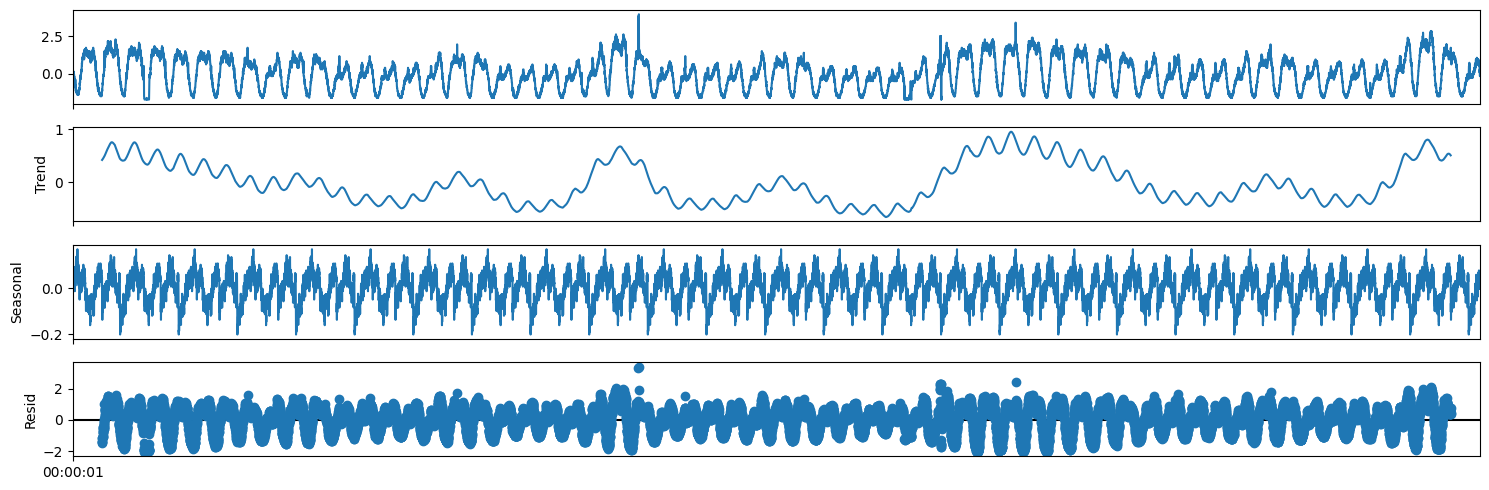

In [34]:
plt.rc('figure',figsize=(15,5))
plt.rc('font',size=10)

result = seasonal_decompose(df_for_seasonal,model='additive', period=732)
fig = result.plot()

# x = result.resid.index
# y = result.resid.values

# Random split train test

In [7]:
# @title
x_train,x_test,y_train, y_test = train_test_split(df[['value','timestamp']], df['label'], test_size=0.2, random_state=42)
print("Train num of rows: ",x_train.shape[0],", Test num of rows: ",x_test.shape[0])

Train num of rows:  14054 , Test num of rows:  3514


# Handeling unbalanced dataset

In [ ]:
# @title
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 13895, 1: 159})


## Tomek links under sampeling
Tomkek link identifies a pair of instances that are close together in feature space, but belong to different classes. These instances are considered noise because they may introduce uncertainty and make it difficult for a classifier to correctly classify the minority class.
To remove the noise, we can remove the instance from the pair that is closer to the majority class. This is based on the assumption that the closer instance to the majority class is more likely to be misclassified than the other instance.
*notice that it's working well only for clear boundery between classes and is computationally expensive when there are a lot of features

In [ ]:
# @title
tl = TomekLinks()
x_tl_res, y_tl_res = tl.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_tl_res))

Resampled dataset shape Counter({0: 13882, 1: 159})


## ADASYN
ADASYN works by generating synthetic data for the minority class that are more difficult to classify by the current model. This is achieved by using a density distribution function to measure the imbalance of the dataset and generate synthetic samples with a higher density in the regions where the minority class is less represented. *notice that it's working well only when the minorty is not too noisy and is computationally expensive when there are a lot of features, also might cause overfitting.

In [ ]:
# @title
x_train_balanced, y_train_balanced = over_sampling_adasyn(x_tl_res,y_tl_res,0.2,3) # if we want complete balance set percent to 1


Original dataset shape Counter({0: 13882, 1: 159})
Original dataset sampled randonly for over sampling shape Counter({0: 2777, 1: 32})
Original dataset sampled to keep as is (avoiding overfitting) shape Counter({0: 11105, 1: 127})
Resampled dataset (after over sampling) shape Counter({0: 2777, 1: 2773})
Resampled dataset (final) shape Counter({0: 13882, 1: 2900})


# Isolation forest

Isolation forest is good for anomaly detection and imbalanced dataset, how it works:
1. Random Partitioning: The algorithm randomly selects a feature and a split value to partition the data at each step. It continues this process recursively until it isolates individual data points or they form small clusters.

2. Anomalies Are Isolated: Anomalies are more likely to be isolated early in the tree-building process because they require fewer splits to be separated from the majority of normal data points.

3. Scoring: The number of splits required to isolate a data point is used as a score. Lower scores indicate anomalies, while higher scores indicate normal data points.

4. Threshold: You can set a threshold to classify data points with scores below it as anomalies.

In [ ]:
percent_of_annomalies=y_train.value_counts()[1]/(y_train.value_counts()[0]+y_train.value_counts()[1])
if_model =  IsolationForest(contamination=percent_of_annomalies,random_state=42) # if contamination is not mentioned then assumed as 50% - 50%
if_model.fit(x_train[['value']])
y_pred_if=pd.Series(if_model.predict(x_test[['value']])).apply(lambda x: 1 if (x == -1) else 0 ) # the model returns -1 for outlier and 1 for inlier
x_test['score_of_abnormal']=if_model.decision_function(x_test[['value']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



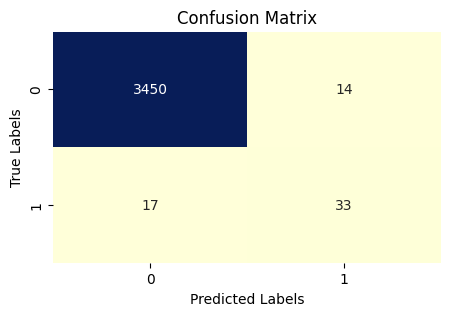

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_if)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',annot_kws={"size":10}, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Create a classification report
class_report = classification_report(y_test, y_pred_if)

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       0.70      0.66      0.68        50

    accuracy                           0.99      3514
   macro avg       0.85      0.83      0.84      3514
weighted avg       0.99      0.99      0.99      3514



The measure of normality of an observation given a tree is the depth of the leaf containing this observation, which is equivalent to the number of splittings required to isolate this point. In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree is added.

The anomaly score of the input samples. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.

Meaning, in this graph. ideal would be for label "1" all are negative (or at least very low), and for label "0" all are positive and high.

In [ ]:
# @title
res_analysis_df=x_test.copy()
res_analysis_df['label']=y_test
res_analysis_df=res_analysis_df.reset_index(drop=True)
res_analysis_df['pred_label']=y_pred_if
fig = px.box(res_analysis_df, x='label', y='score_of_abnormal', color='label',color_discrete_sequence=['navy','salmon'],title="Box plot of score of abnoraml per label")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:
# @title
res_analysis_df['confusion_matrix'] = np.where((res_analysis_df['label']==1) & (res_analysis_df['pred_label']==1), 'tp',
                                      np.where(((res_analysis_df['label']==0) & (res_analysis_df['pred_label']==1)), 'fp',
                                      np.where(((res_analysis_df['label']==1) & (res_analysis_df['pred_label']==0)), 'fn', 'tn')))

viz_true_vs_pred_labels(res_analysis_df,'timestamp','value','confusion_matrix')


## Isolation forest on balanced dataset

In [ ]:
# @title
if_balanced_model =  IsolationForest(contamination=percent_of_annomalies,random_state=42) # if contamination is not mentioned then assumed as 50% - 50%
if_balanced_model.fit(x_train_balanced[['value']])
y_pred_if_balanced=pd.Series(if_balanced_model.predict(x_test[['value']])).apply(lambda x: 1 if (x == -1) else 0 ) # the model returns -1 for outlier and 1 for inlier


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



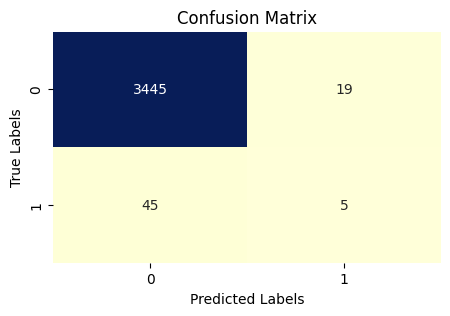

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_if_balanced)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',annot_kws={"size":10}, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Create a classification report
class_report = classification_report(y_test, y_pred_if)

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       0.70      0.66      0.68        50

    accuracy                           0.99      3514
   macro avg       0.85      0.83      0.84      3514
weighted avg       0.99      0.99      0.99      3514



# Autoencoder

Using autoencoder (nn that the imput size==output size, the network has phase 1 od encoder - reduction of dimentionality from input dimention to x, and phase 2 takes the encoder result and bring it back to the input dimention)-  to understand which point is anomly, the process works like this:
1. Creating the model
2. Getting the models reconstracted vector
3. Calculating the error per point, mean error and error std
4. Defining threshold (based on mean and std, for example error > mean +3 std)
5. If the differance between the reconstracted point and the actual point is bigget then ths it's Anomaly

** for time series vectors - the input is sequence of the time series - let's say we have 90 days data and 100 points per day, we will devide the data into time windows of 10 in this way : [1,2,3,4,5,6,7,8,9,10,11...]->[[1,2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11],[3,4,5,6,7,8,9,10,11,12]...]
after we got reconstracted vectors we can avg the results to cals the differance from the original

In [10]:
print("Samples number: ",df.shape[0])
df.head()

Samples number:  17568


timestamp     value  label
0  1469376000  0.847300      0
1  1469376300 -0.036137      0
2  1469376600  0.074292      0
3  1469376900  0.074292      0
4  1469377200 -0.036137      0

## split train test base on time

In [11]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [12]:
df['datetime']=df['timestamp'].apply(lambda x: pd.to_datetime(x))
total_h=pd.Timedelta(df['datetime'][0] - df['datetime'][df.shape[0]-1]).seconds/3600
print("The data include: ",total_h, 'hours')
print("Every hour there are ",df.shape[0]/total_h, "data points")

The data include:  23.99972222222222 hours
Every hour there are  732.0084723202815 data points


In [13]:
# create df of values and idx only
df_for_model=df[['value']]
df_for_model=df_for_model.set_index(df['datetime'])
#devide into train val and test
train_df=df_for_model[:13176] # taining 18 hours (75%) 24 hours * 0.75 = 18 hours, 18*732=13176
val_df=df_for_model[13176:15372] # validation 3 hours (12.5%) 3*732=2196, 13176+2196=15372
test_df=df_for_model[15372:] # test 3 hours (12.5%)
test_df.shape

(2196, 1)

## prep data

### normalize data

In [14]:
# calc general mean & std
df_for_normalized=df[['value','label']]
df_for_normalized=df_for_normalized[:13176] # taking only train data
df_without_anomaly=df_for_normalized.loc[df_for_normalized['label']==0]
training_mean = df_without_anomaly['value'].mean()
training_std = df_without_anomaly['value'].std()

training_df_norm = (train_df - training_mean) / training_std
validation_df_norm = (val_df - training_mean) / training_std
test_df_norm = (test_df - training_mean) / training_std

print("Number of training samples:", len(training_df_norm))
print("Number of validation samples:", len(validation_df_norm))
print("Number of test samples:", len(test_df_norm))

training_df_norm.head()

Number of training samples: 13176
Number of validation samples: 2196
Number of test samples: 2196


value
datetime                               
1970-01-01 00:00:01.469376000  0.812954
1970-01-01 00:00:01.469376300 -0.070014
1970-01-01 00:00:01.469376600  0.040357
1970-01-01 00:00:01.469376900  0.040357
1970-01-01 00:00:01.469377200 -0.070014

### create sequences

In [15]:
x_train = create_sequences(training_df_norm.values.reshape(training_df_norm.shape[0]),732)
x_val= create_sequences(validation_df_norm.values.reshape(validation_df_norm.shape[0]),732)
x_test= create_sequences(test_df_norm.values.reshape(test_df_norm.shape[0]),732)
print("Training input shape: ", x_train.shape)
print("Validation input shape: ", x_val.shape)

Training input shape:  (12445, 732)
Validation input shape:  (1465, 732)


### data loaders

In [16]:
tensor_train = torch.tensor(x_train,dtype=torch.float32).to(device)
train = data_utils.TensorDataset(tensor_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=2489, shuffle=True) # batch size = train size/5

In [17]:
tensor_val = torch.tensor(x_val,dtype=torch.float32).to(device)
val = data_utils.TensorDataset(tensor_val)
val_loader = torch.utils.data.DataLoader(val, batch_size=2489, shuffle=True) # batch size = train size/5

## build model

In [18]:
evenRound = lambda f: round(f/2.)*2 ## Round to the nearest even number

#Model architecture
# 1. Linear transformation layers
# 2. LeakyReLU as the activation function
class Autoencoder(nn.Module):
    def __init__(self,input_dim):
        super(Autoencoder,self).__init__()

        #Encoder
        self.encoder = torch.nn.Sequential(
            nn.Linear(input_dim, int(input_dim/2)),
            nn.LeakyReLU(),
            nn.Linear(int(input_dim/2), int(evenRound(input_dim/4))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/4)), int(evenRound(input_dim/8))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/8)), int(evenRound(input_dim/16))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/16)), int(evenRound(input_dim/32))),
            # nn.LeakyReLU(),
            # nn.Linear(int(evenRound(input_dim/32)), int(evenRound(input_dim/64)))
        )
        #Decoder
        self.decoder = torch.nn.Sequential(
            # nn.Linear(int(evenRound(input_dim/64)),int(evenRound(input_dim/32))),
            # nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/32)),int(evenRound(input_dim/16))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/16)),int(evenRound(input_dim/8))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/8)), int(evenRound(input_dim/4))),
            nn.LeakyReLU(),
            nn.Linear(int(evenRound(input_dim/4)), int(input_dim/2)),
            nn.LeakyReLU(),
            nn.Linear(int(input_dim/2), input_dim),
            nn.Identity() #linear activation function
        )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [19]:
#define dimensions
input_dim = x_train.shape[1]
#define hyper params
epochs = 30 # based on the train-val-loss plot

model = Autoencoder(input_dim)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=732, out_features=366, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=366, out_features=184, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=184, out_features=92, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=92, out_features=46, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=46, out_features=22, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=22, out_features=46, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=46, out_features=92, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=92, out_features=184, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=184, out_features=366, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=366, out_features=732, bias=True)
   

## training loop

In [20]:
#outputs = []
loss_train_lst = []
loss_val_lst = []
lr_start = 0.0005
train_loss = 0.0
val_loss = 0.0
len_train_dataset=x_train.shape[0]
len_val_dataset=x_val.shape[0]

for epoch in range(epochs):
    model.train()
    if epoch==0:
      lr_rate = lr_start
    lr_rate = 0.9*lr_rate
    optim = torch.optim.Adam(model.parameters(), lr=lr_rate,weight_decay=0.0001) # adam optimizer with Weight decay regularization L2
    for i, inputs in enumerate(train_loader): # for each batch
      optim.zero_grad()# The gradients are set to zero
      # Output of Autoencoder
      outputs = model(inputs[0])
      # Calculating the loss function
      loss_t = torch.nn.functional.mse_loss(outputs,inputs[0])

      # the the gradient is computed and stored.
      # .step() performs parameter update
      optim.zero_grad()
      loss_t.backward()
      optim.step()
      train_loss += loss_t.item() * len(inputs[0])  # loss * batch size
    train_loss /= len_train_dataset # avg loss between batches
    loss_train_lst.append(train_loss)# Storing the losses in a list for plotting
    with torch.no_grad():
        for (inputs) in val_loader:
            reconstructed = model(inputs[0])
            #loss_w = loss_w * (reconstructed >= 0).float() # ignore preds with values less than 0.5 (i.e those that we predict are 0)
            loss_v = torch.nn.functional.mse_loss(reconstructed, inputs[0])
            val_loss += loss_t.item() * len(inputs[0])  # loss * batch size
            #loss=loss_fun(reconstructed,inputs[0].cuda())
    val_loss /= len_val_dataset
    loss_val_lst.append(val_loss)
    if epoch % 10 == 0 :
      print("finished. epoch:", epoch, "last train loss: ", loss_train_lst[-1], "last val loss:", loss_val_lst[-1])


finished. epoch: 0 last train loss:  1.013760757446289 last val loss: 1.0178906917572021
finished. epoch: 10 last train loss:  0.7261239011760748 last val loss: 0.6863241190766096
finished. epoch: 20 last train loss:  0.38193642990025095 last val loss: 0.3814647557213548


In [21]:
results_summary_train=pd.DataFrame(loss_train_lst,columns =['loss'])
results_summary_train['epoch']=results_summary_train.index+1
results_summary_train['phase']="train"

results_summary_val=pd.DataFrame(loss_val_lst,columns =['loss'])
results_summary_val['epoch']=results_summary_val.index+1
results_summary_val['phase']="val"
results_summary=pd.concat([results_summary_train, results_summary_val])
results_summary.head()

loss  epoch  phase
0  1.013761      1  train
1  1.012893      2  train
2  1.012106      3  train
3  1.010465      4  train
4  1.005499      5  train

In [22]:
fig = px.line(results_summary, x="epoch", y="loss", color='phase',color_discrete_sequence=[px.colors.qualitative.Pastel[4],px.colors.qualitative.Pastel[0]],title="loss per epoch")
fig.show()

## predict

In [23]:
test_df_for_prediction=test_df.values.reshape(3,732).shape

In [24]:
tensor_test = torch.tensor(x_test,dtype=torch.float32).to(device)
test_reconstructed=model(tensor_test)

In [25]:
test_reconstructed_np=test_reconstructed.cpu().detach().numpy()

In [26]:
test_predictions = reverse_sequences_to_vector(test_reconstructed_np)

In [27]:
test_mae_loss = np.mean(np.abs(test_predictions - test_df_norm.values), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
threshold = np.mean(test_mae_loss) + 3*np.std(test_mae_loss)

In [28]:
anomalies = (test_mae_loss > threshold)*1 # the "*1" transform false/positive into 0/1

## get results

In [30]:
labeled_test=df[15372:]
print(labeled_test.shape)
labeled_test.head()

(2196, 4)


timestamp     value  label                      datetime
15372  1473987600 -0.588286      0 1970-01-01 00:00:01.473987600
15373  1473987900 -0.698716      0 1970-01-01 00:00:01.473987900
15374  1473988200 -0.698716      0 1970-01-01 00:00:01.473988200
15375  1473988500 -0.588286      0 1970-01-01 00:00:01.473988500
15376  1473988800 -0.477856      0 1970-01-01 00:00:01.473988800

In [53]:
print("predicted anomalies:",len(anomalies[(anomalies>0) ]))
print("true anomalies:",labeled_test['label'].loc[labeled_test['label']>0].shape[0])

predicted anomalies: 24
true anomalies: 3


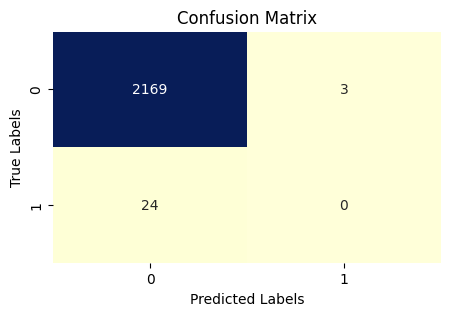

In [47]:
# Create a confusion matrix
conf_matrix = confusion_matrix(labeled_test['label'], anomalies)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',annot_kws={"size":10}, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Create a classification report
class_report = classification_report(labeled_test['label'], anomalies)

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2193
           1       0.00      0.00      0.00         3

    accuracy                           0.99      2196
   macro avg       0.50      0.49      0.50      2196
weighted avg       1.00      0.99      0.99      2196



# DBscan

NOTE - DBscan doesn't have the option of prediction from exsiting model - therefore no point of splitting train test.

For finiding anomalies using dbscan we will pslit the data into clusters, the data points left as -1 are anomalies that didn't fit to any other cluster

## feature engineering

In [46]:
df['datetime']=df['timestamp'].apply(lambda x: pd.to_datetime(x))
df=df.set_index(df['datetime'])
df.head()

timestamp     value  label  \
datetime                                                     
1970-01-01 00:00:01.469376000  1469376000  0.847300      0   
1970-01-01 00:00:01.469376300  1469376300 -0.036137      0   
1970-01-01 00:00:01.469376600  1469376600  0.074292      0   
1970-01-01 00:00:01.469376900  1469376900  0.074292      0   
1970-01-01 00:00:01.469377200  1469377200 -0.036137      0   

                                                   datetime  
datetime                                                     
1970-01-01 00:00:01.469376000 1970-01-01 00:00:01.469376000  
1970-01-01 00:00:01.469376300 1970-01-01 00:00:01.469376300  
1970-01-01 00:00:01.469376600 1970-01-01 00:00:01.469376600  
1970-01-01 00:00:01.469376900 1970-01-01 00:00:01.469376900  
1970-01-01 00:00:01.469377200 1970-01-01 00:00:01.469377200

In [47]:
df_for_seasonal=df[['value']]
df_for_seasonal=df_for_seasonal.set_index(df['datetime'])
splitted_time_features = seasonal_decompose(df_for_seasonal,model='additive', period=732)
df_for_seasonal['seasonal'] = splitted_time_features.seasonal.values
df_for_seasonal['trend'] = splitted_time_features.trend.values # trend can have nulls
df_for_seasonal['trend'] = df_for_seasonal['trend'].fillna(0)
df_db=df_for_seasonal[['value','seasonal','trend']]
df_db['label']=df['label']
df_db.head()

value  seasonal  trend  label
datetime                                                       
1970-01-01 00:00:01.469376000  0.847300  0.051374    0.0      0
1970-01-01 00:00:01.469376300 -0.036137  0.008018    0.0      0
1970-01-01 00:00:01.469376600  0.074292  0.007896    0.0      0
1970-01-01 00:00:01.469376900  0.074292  0.031788    0.0      0
1970-01-01 00:00:01.469377200 -0.036137  0.055693    0.0      0

## scale data

In [123]:
scaler2 = MinMaxScaler()
scaler2.fit(df_db)
scaled2 = scaler2.transform(df_db)
clustering_data = pd.DataFrame(scaled2, columns=df_db.columns.to_list(),index=df_db.index).sort_index(ascending=True)
clustering_data.head()

value  seasonal     trend  label
datetime                                                          
1970-01-01 00:00:01.469376000  0.450980  0.681342  0.405208    0.0
1970-01-01 00:00:01.469376300  0.294118  0.564304  0.405208    0.0
1970-01-01 00:00:01.469376600  0.313725  0.563977  0.405208    0.0
1970-01-01 00:00:01.469376900  0.313725  0.628472  0.405208    0.0
1970-01-01 00:00:01.469377200  0.294118  0.693002  0.405208    0.0

## choose parameters

In [58]:
def find_the_best_epsilon_for_dbscan_knng(X,neighbors):
  nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(X)
  distances = nbrs.kneighbors(X)
  #get distances
  knn_dist = pd.DataFrame(distances[0])
  #create cols list
  col_lst=[]
  for i in range(1,knn_dist.shape[1]): col_lst.append(i)
  #calc the avg distance per point and sort asc
  knn_dist['avg_distance']=knn_dist[col_lst].mean(axis=1)
  knn_dist=knn_dist.sort_values(by=['avg_distance']).reset_index()
  knn_dist['sorted_point'] = knn_dist.index
  knn_dist=knn_dist[['sorted_point','avg_distance']]
  # plot knng
  fig = px.line(knn_dist, x="sorted_point", y="avg_distance",color_discrete_sequence=px.colors.qualitative.Pastel, text="avg_distance",title='k-nearest neighbor graph, K='+str(neighbors))
  fig.update_traces(textposition="bottom right")
  fig.show()

In [77]:

def opt_params_dbscan_silhouette(X,search_grid_epsilon_lst,search_grid_min_pts_lst):
  search_geid_df = pd.DataFrame(list(zip(search_grid_min_pts_lst, search_grid_epsilon_lst)),columns =['min_pts', 'epsilon'])
  df_results = pd.DataFrame(columns=['params','silhouette_score','fotmated_score'])
  for index, row in search_geid_df.iterrows():
    dbscan = DBSCAN(eps=row['epsilon'], min_samples=int(row['min_pts'])).fit(X)
    labels=dbscan.labels_
    score=sklearn.metrics.silhouette_score(X, labels, metric='euclidean')
    new_row = {'params':"epsilon="+str(row['epsilon'])+", +min_pts="+str(row['min_pts']),'silhouette_score':score,'fotmated_score':"%.2f" % score}
    df_results = df_results.append(new_row, ignore_index=True) # soon need to replace append -> concat
  fig3 = px.line(df_results, x="params", y="silhouette_score",color_discrete_sequence=px.colors.qualitative.Pastel, text="fotmated_score",title='DBSCAN-find the best params')
  fig3.update_traces(textposition="bottom right")
  fig3.show()


In [98]:
def present_eval_for_chosen_model(X,model):
  # get labels pf class
  labels=model.labels_
  # reduce dimension into 2 using PCA for visualisation
  pca = decomposition.PCA(n_components=2)
  pca.fit(X)
  pca_model = pca.transform(X)
  pca_model_df = pd.DataFrame(pca_model, columns = ['Column_A','Column_B'])
  pca_model_df['labels']=labels
  pca_model_df['labels_str']=pca_model_df['labels'].astype(str)
  # combine labels and X
  model_res=X
  model_res['label']=labels
  model_res['label']=model_res['label'].astype(str)

  # print split distrabution and score
  print("The split of the data between clusters: \n",model_res['label'].value_counts())
  db_score=sklearn.metrics.davies_bouldin_score(X, labels)
  print("Davis Bouldin score: ","%.4f" % db_score)
  # print scatter plot of pca
  fig = px.scatter(pca_model_df, x="Column_A", y="Column_B", color="labels_str",title='DBSCAN labels split (PCA dimensions)'
                  ,color_discrete_sequence=px.colors.qualitative.Pastel,width=800, height=1000)
  fig.show()
 # print scater plot of all combinations
  data_cols=model_res.loc[:, model_res.columns != 'label'].columns.to_list()
  fig2 = px.scatter_matrix(model_res, dimensions=data_cols,color='label',title='DBSCAN labels split, matrix of all features'
                           ,color_discrete_sequence=px.colors.qualitative.Pastel,width=800, height=1000)
  fig2.show()

  return model_res

In [125]:
df_for_db=clustering_data[['value','seasonal','trend']]
df_for_db.head()

value  seasonal     trend
datetime                                                   
1970-01-01 00:00:01.469376000  0.450980  0.681342  0.405208
1970-01-01 00:00:01.469376300  0.294118  0.564304  0.405208
1970-01-01 00:00:01.469376600  0.313725  0.563977  0.405208
1970-01-01 00:00:01.469376900  0.313725  0.628472  0.405208
1970-01-01 00:00:01.469377200  0.294118  0.693002  0.405208

In [126]:
min_pts_search_lst=range((df_for_db.shape[1]*2)-4,(df_for_db.shape[1]*2)+5,2)
for min_pts in min_pts_search_lst:
  find_the_best_epsilon_for_dbscan_knng(df_for_db,min_pts)

using the knng we can find for given k the best epsilon - where we have using the elbow method



In [106]:
chosen_epsilons = [0.037, 0.043, 0.048, 0.051, 0.057] #matching epsilon the the k in the graphs
opt_params_dbscan_silhouette(clustering_data,chosen_epsilons,min_pts_search_lst) #search grid for the combination of min-points and epsilon for the best model

<ipython-input-77-a1ddb3a45e6e>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-77-a1ddb3a45e6e>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-77-a1ddb3a45e6e>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-77-a1ddb3a45e6e>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-77-a1ddb3a45e6e>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Best parameters are given by the best silhouette score (the highest scroe) - epsilon=0.051,min_points=8


## create and eval model

In [127]:
epsilon=0.051
min_samples=8
model = DBSCAN(eps=epsilon, min_samples=min_pts).fit(df_for_db)

In [128]:
results = present_eval_for_chosen_model(df_for_db,model)

The split of the data between clusters: 
 0     17142
-1      403
2        13
1        10
Name: label, dtype: int64
Davis Bouldin score:  0.4982


## get results

In [134]:
results['true_label']=clustering_data['label']
results["true_label"] = results["true_label"].astype(int)

results['predicted_anomaly_label']=0
results['predicted_anomaly_label'].loc[results['label']=='-1']=1
results.head()

<ipython-input-134-58d97ac289c8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



value  seasonal     trend label  true_label  \
datetime                                                                        
1970-01-01 00:00:01.469376000  0.450980  0.681342  0.405208     0           0   
1970-01-01 00:00:01.469376300  0.294118  0.564304  0.405208     0           0   
1970-01-01 00:00:01.469376600  0.313725  0.563977  0.405208     0           0   
1970-01-01 00:00:01.469376900  0.313725  0.628472  0.405208     0           0   
1970-01-01 00:00:01.469377200  0.294118  0.693002  0.405208     0           0   

                               predicted_anomaly_label  
datetime                                                
1970-01-01 00:00:01.469376000                        0  
1970-01-01 00:00:01.469376300                        0  
1970-01-01 00:00:01.469376600                        0  
1970-01-01 00:00:01.469376900                        0  
1970-01-01 00:00:01.469377200                        0

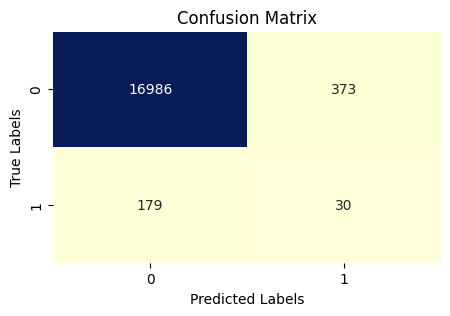

In [135]:
# Create a confusion matrix
conf_matrix = confusion_matrix(results['true_label'], results['predicted_anomaly_label'])

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',annot_kws={"size":10}, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [136]:
# Create a classification report
class_report = classification_report(results['true_label'], results['predicted_anomaly_label'])

# Print the classification report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     17359
           1       0.07      0.14      0.10       209

    accuracy                           0.97     17568
   macro avg       0.53      0.56      0.54     17568
weighted avg       0.98      0.97      0.97     17568

